<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/LSTM/LSTM_Best_Optimizer_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [1]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dropout, Dense
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [3]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


# Data Preprocessing

In [4]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [5]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [6]:
# Check Missing Values
df.isnull().sum()

,0
Date,0
Time,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [7]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


# Data Imputation

In [8]:
# Check Missing Values
df.isnull().sum()

,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [9]:
# Apply MICE imputer
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Fill NaN values using the mean for each column
#df_imputed = df.copy()
#df_imputed.fillna(df.mean(), inplace=True)

# Check Missing Values after imputation
df_imputed.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [10]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
date_time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766667
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733333
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333


In [11]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()

# Save DataFrame to a CSV file
hourly_resampled.to_csv('hourly_resampled.csv')

Note:- As Global_intensity is highly correlated with Global_active_power so I am removing Global_intensity column

In [12]:
df1 = hourly_resampled.drop(['Global_intensity'], axis=1)
df1

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
date_time,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,0.0,0.527778,16.861111,52.992593
2006-12-16 18:00:00,3.632200,0.080033,234.580167,0.0,6.716667,16.866667,36.953333
2006-12-16 19:00:00,3.400233,0.085233,233.232500,0.0,1.433333,16.683333,38.553889
2006-12-16 20:00:00,3.268567,0.075100,234.071500,0.0,0.000000,16.783333,37.692778
2006-12-16 21:00:00,3.056467,0.076667,237.158667,0.0,0.416667,17.216667,33.307778
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,0.0,0.000000,12.866667,15.898333
2010-11-26 18:00:00,1.573467,0.053700,237.531833,0.0,0.000000,0.000000,26.224444
2010-11-26 19:00:00,1.659333,0.060033,236.741000,0.0,0.066667,0.000000,27.588889


# Data Normalization

In [13]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df1)

# Shape of scaled data
scaled_df

# LSTM-1 optimizer=Adam epochs=50 batch_size=32

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,301 (169.14 KB)

 Trainable params: 43,301 (169.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
757/757 - 6s - 8ms/step - loss: 0.0110 - val_loss: 0.0078
Epoch 2/50
757/757 - 4s - 5ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 3/50
757/757 - 4s - 6ms/step - loss: 0.0084 - val_loss: 0.0073
Epoch 4/50
757/757 - 4s - 6ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 5/50
757/757 - 6s - 8ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 6/50
757/757 - 4s - 6ms/step - loss: 0.0080 - val_loss: 0.0068


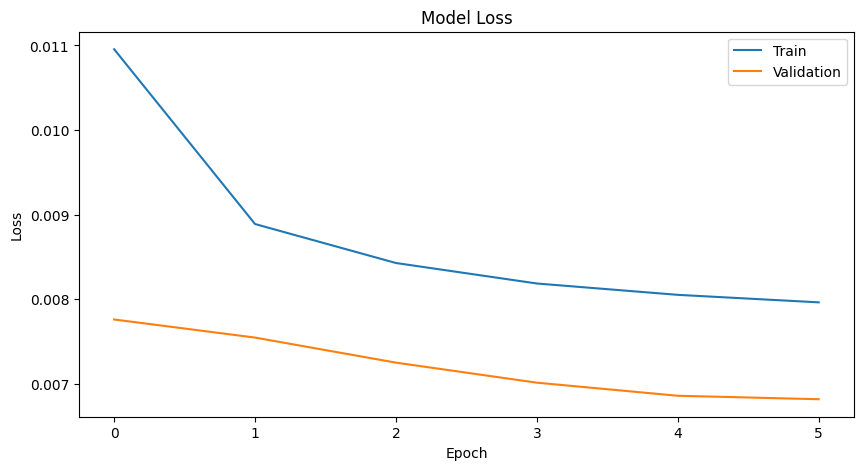

757/757 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train Mean Absolute Error: 0.41153459141637944
Train Mean Squared Error: 0.33992183696737305
Train Root Mean Squared Error: 0.583028161384485

Test Mean Absolute Error: 0.3804562299292813
Test Mean Squared Error: 0.28253757085352266
Test Root Mean Squared Error: 0.5315426331476363


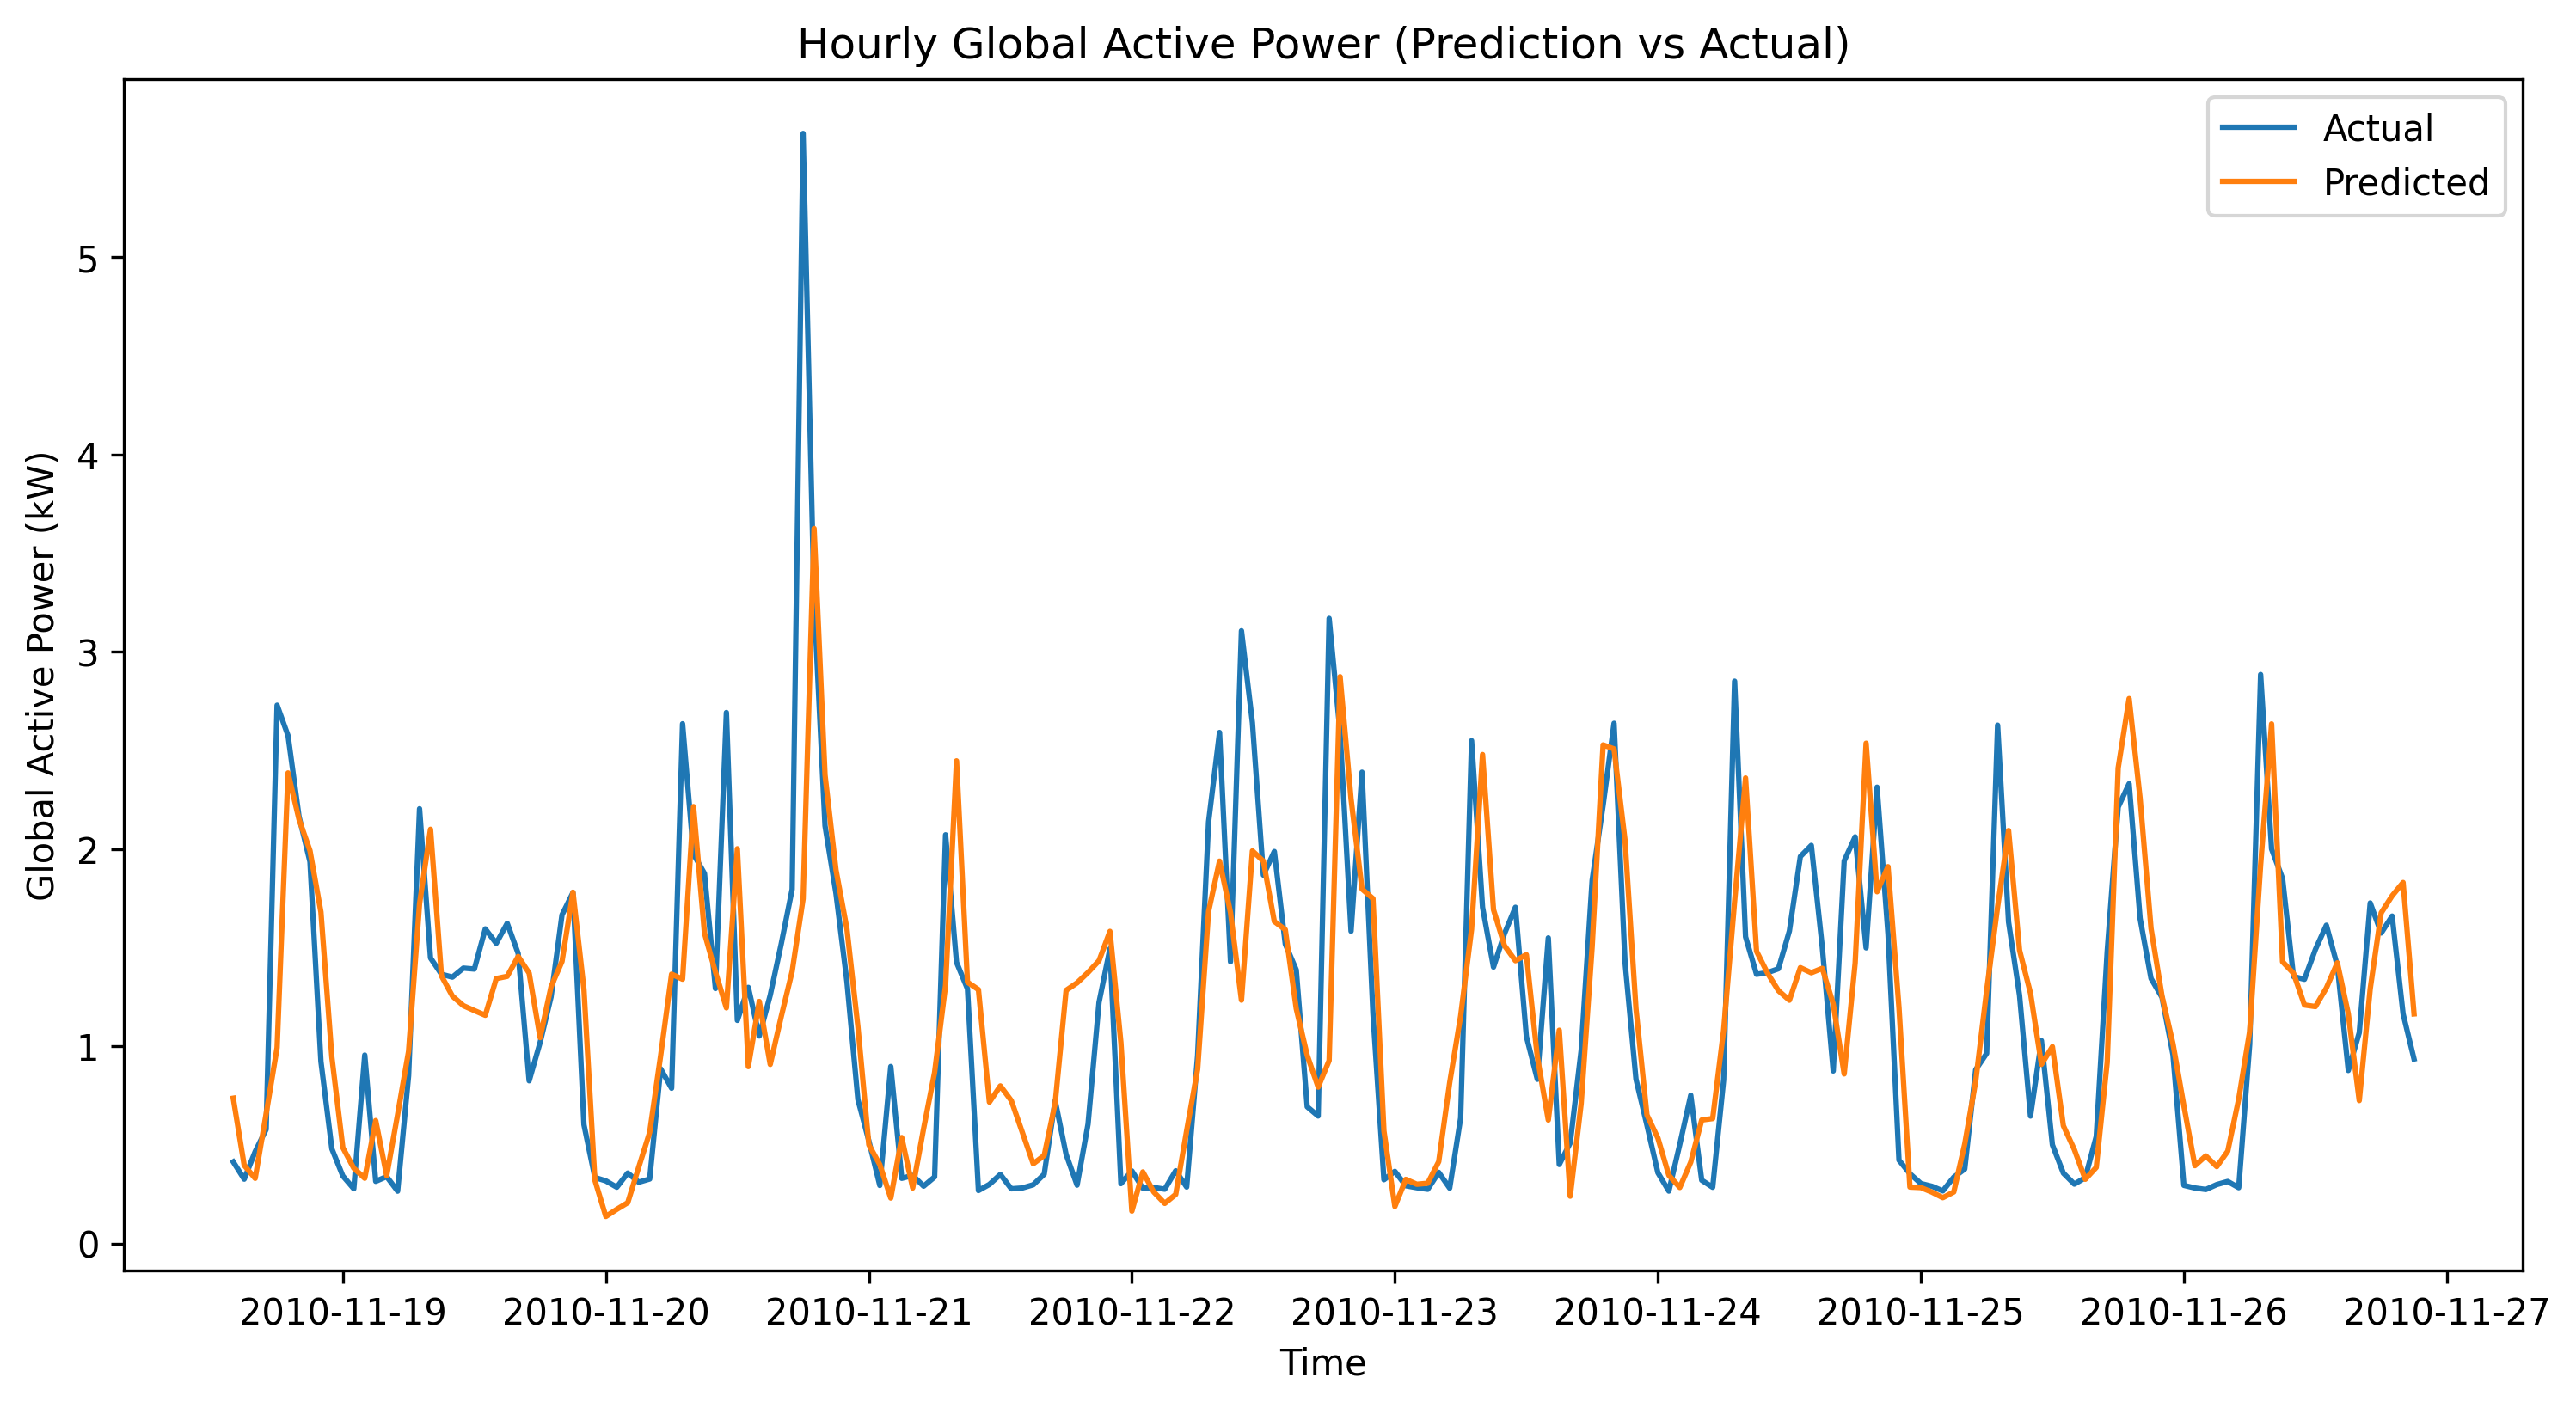

In [18]:
# Define sequence length and features
sequence_length = 24             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.7 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train Mean Absolute Error:', mean_absolute_error(true_train_y, pred_train_y))
print('Train Mean Squared Error:', mean_squared_error(true_train_y, pred_train_y))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest Mean Absolute Error:', mean_absolute_error(true_test_y, pred_test_y))
print('Test Mean Squared Error:', mean_squared_error(true_test_y, pred_test_y))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM-2 optimizer=SGD epochs=50 batch_size=32

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,301 (169.14 KB)

 Trainable params: 43,301 (169.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
757/757 - 6s - 8ms/step - loss: 0.0186 - val_loss: 0.0127
Epoch 2/50
757/757 - 11s - 15ms/step - loss: 0.0158 - val_loss: 0.0120
Epoch 3/50
757/757 - 4s - 5ms/step - loss: 0.0149 - val_loss: 0.0116
Epoch 4/50
757/757 - 3s - 4ms/step - loss: 0.0143 - val_loss: 0.0113
Epoch 5/50
757/757 - 4s - 5ms/step - loss: 0.0139 - val_loss: 0.0111
Epoch 6/50
757/757 - 4s - 5ms/step - loss: 0.0136 - val_loss: 0.0109


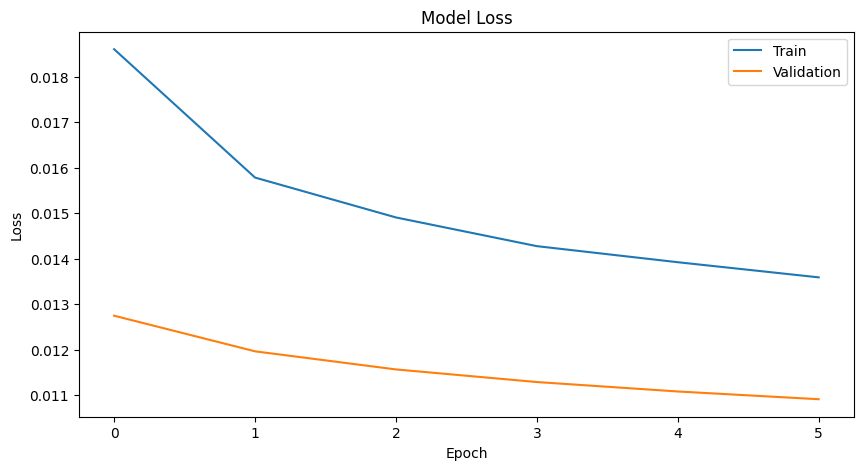

757/757 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train Mean Absolute Error: 0.5571366628639326
Train Mean Squared Error: 0.5627663241214051
Train Root Mean Squared Error: 0.7501775284033808

Test Mean Absolute Error: 0.49910973387850704
Test Mean Squared Error: 0.45199465748760764
Test Root Mean Squared Error: 0.6723054792931615


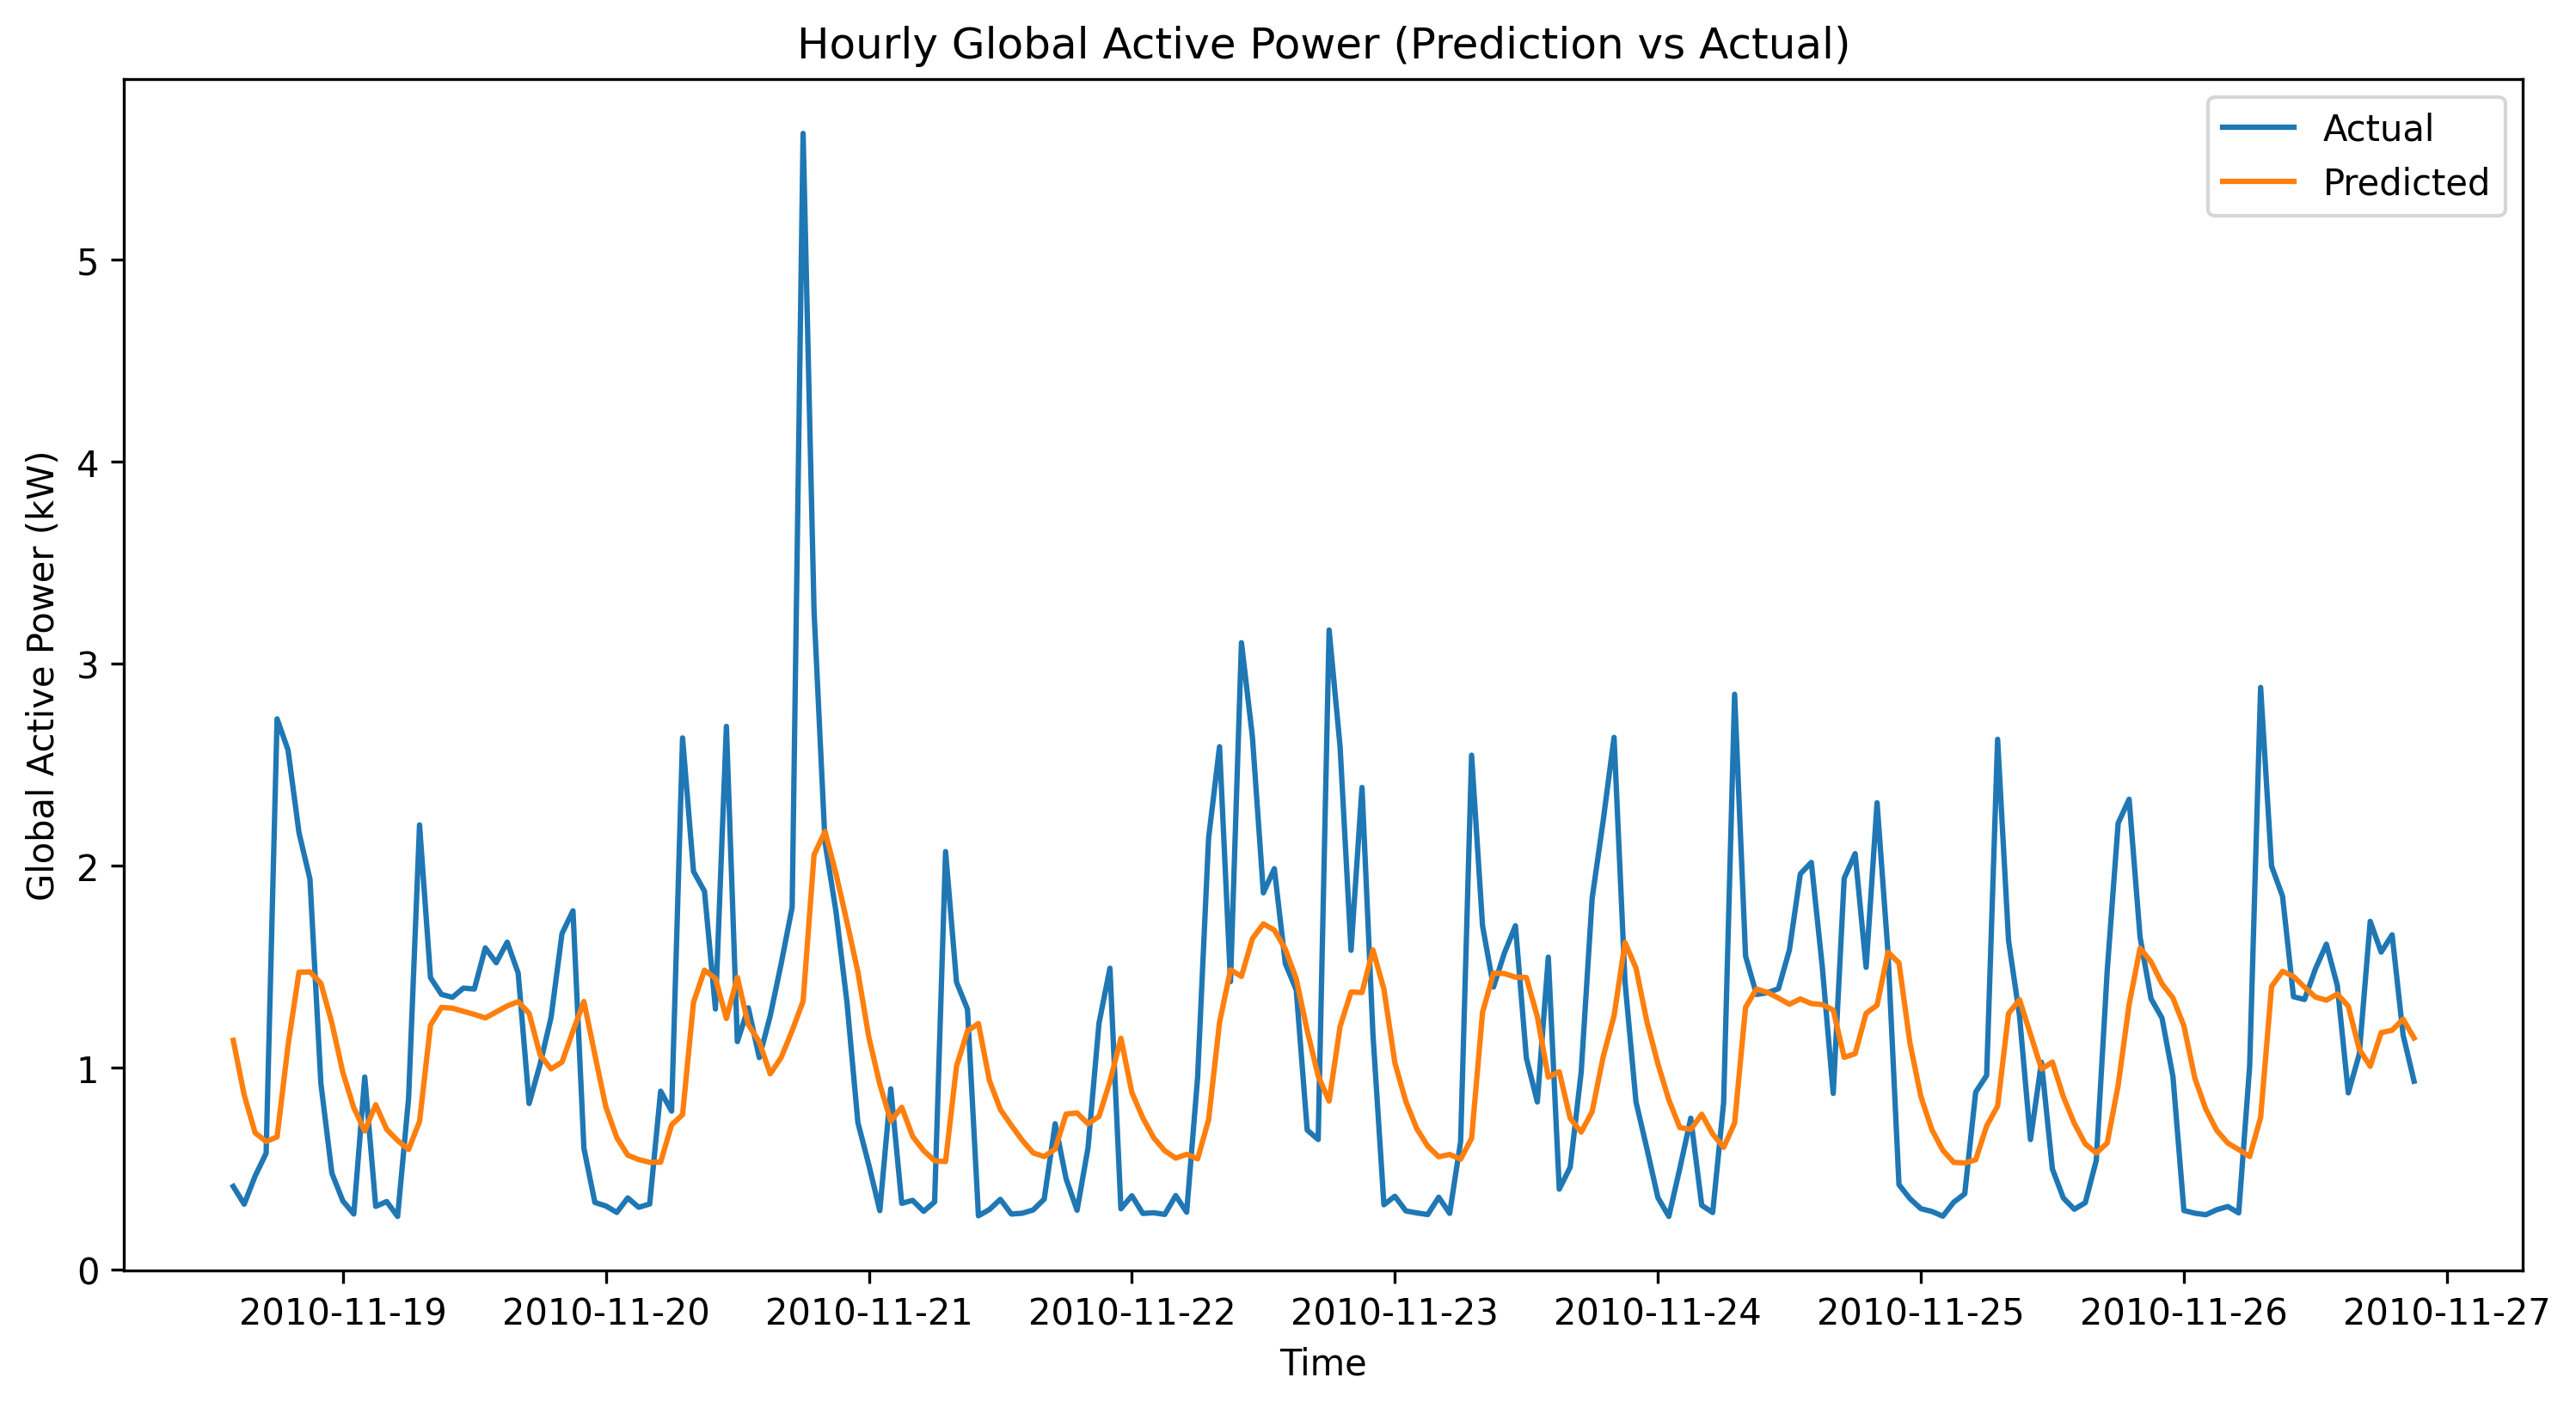

In [19]:
# Define sequence length and features
sequence_length = 24             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.7 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=SGD(), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train Mean Absolute Error:', mean_absolute_error(true_train_y, pred_train_y))
print('Train Mean Squared Error:', mean_squared_error(true_train_y, pred_train_y))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest Mean Absolute Error:', mean_absolute_error(true_test_y, pred_test_y))
print('Test Mean Squared Error:', mean_squared_error(true_test_y, pred_test_y))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

#LSTM-3 optimizer=RMSprop epochs=50 batch_size=32

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,301 (169.14 KB)

 Trainable params: 43,301 (169.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
757/757 - 5s - 7ms/step - loss: 0.0112 - val_loss: 0.0084
Epoch 2/50
757/757 - 4s - 5ms/step - loss: 0.0092 - val_loss: 0.0079
Epoch 3/50
757/757 - 3s - 4ms/step - loss: 0.0090 - val_loss: 0.0076
Epoch 4/50
757/757 - 6s - 8ms/step - loss: 0.0088 - val_loss: 0.0076
Epoch 5/50
757/757 - 4s - 5ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 6/50
757/757 - 4s - 5ms/step - loss: 0.0088 - val_loss: 0.0079


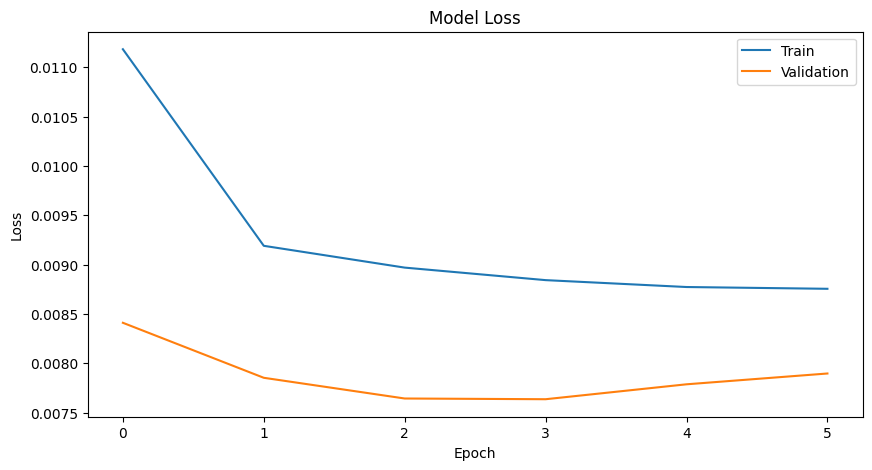

757/757 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train Mean Absolute Error: 0.5005119510125794
Train Mean Squared Error: 0.405151441078325
Train Root Mean Squared Error: 0.6365150752954127

Test Mean Absolute Error: 0.4472486648275894
Test Mean Squared Error: 0.32716075016191276
Test Root Mean Squared Error: 0.5719796763539005


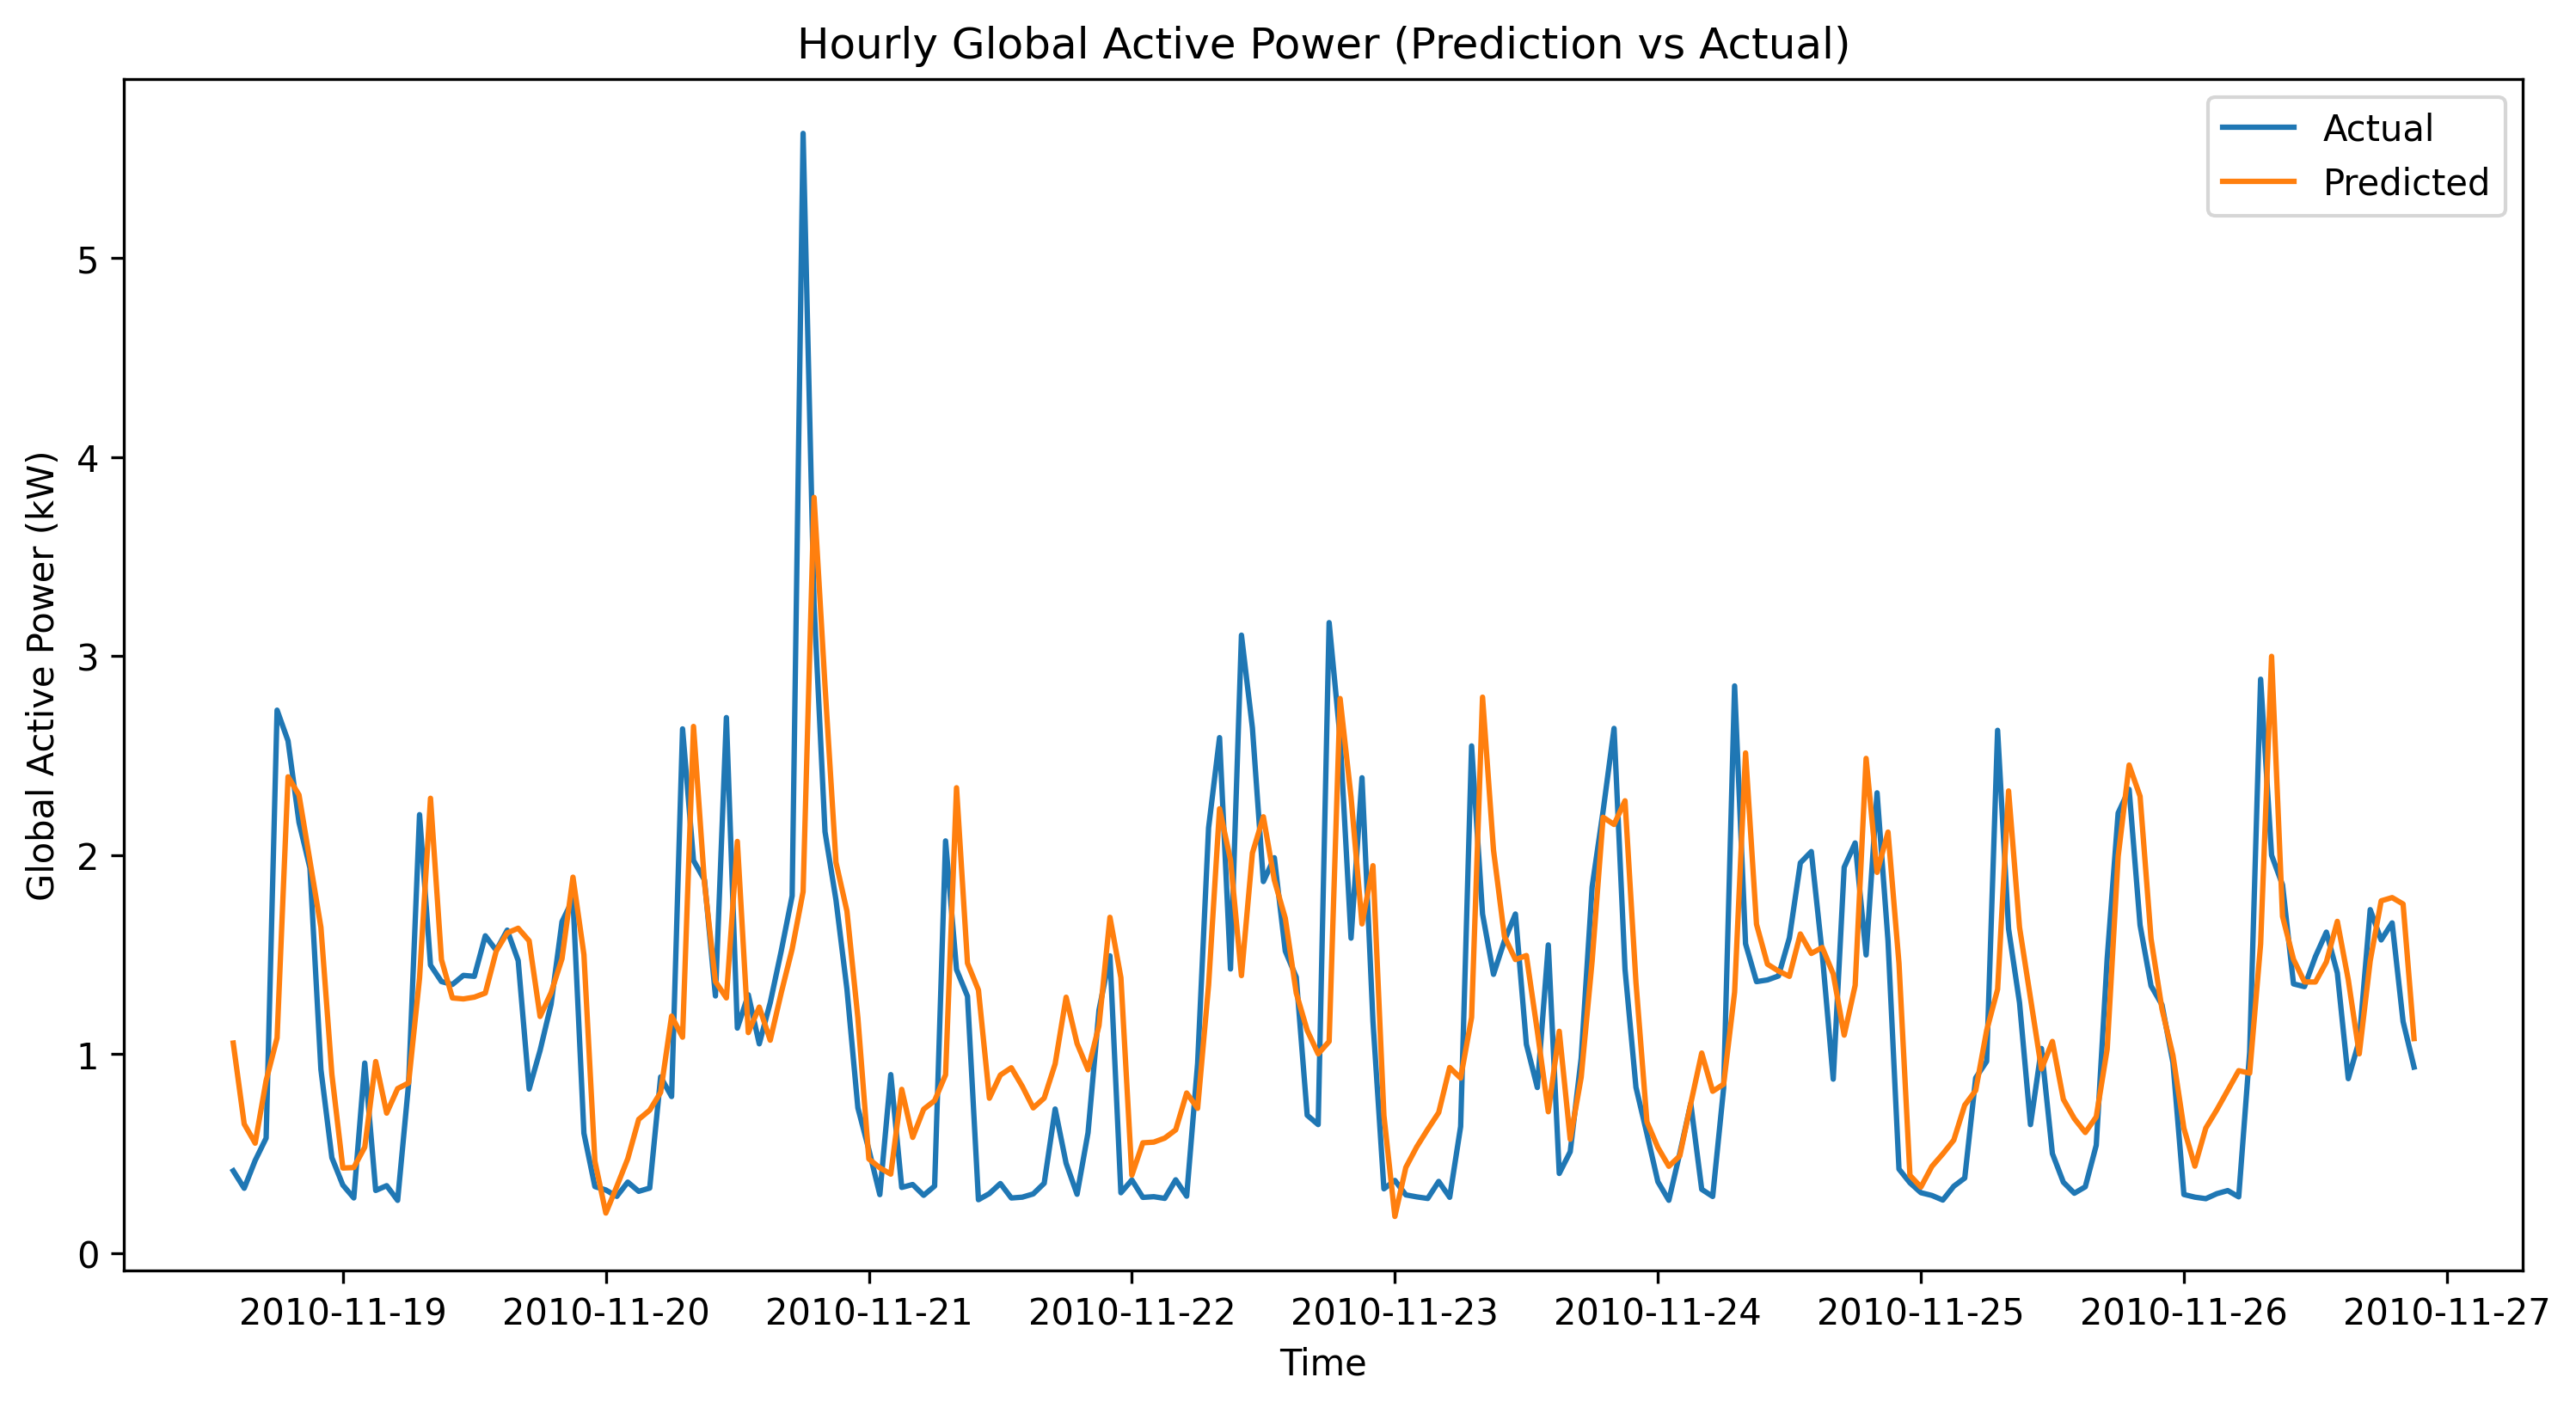

In [20]:
# Define sequence length and features
sequence_length = 24             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.7 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=RMSprop(), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train Mean Absolute Error:', mean_absolute_error(true_train_y, pred_train_y))
print('Train Mean Squared Error:', mean_squared_error(true_train_y, pred_train_y))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest Mean Absolute Error:', mean_absolute_error(true_test_y, pred_test_y))
print('Test Mean Squared Error:', mean_squared_error(true_test_y, pred_test_y))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

In [ ]:
# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'Train MAPE: {mean_absolute_percentage_error(true_y_test, pred_y_test):.3f}%')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()